# Objective
* 20181225: 
    * Predict stock price in next day using XGBoost
    * Given prices and other features for the last N days, we do prediction for day N+1
    * Here we split 3 years of data into train(60%), dev(20%) and test(20%)

In [26]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
from xgboost import XGBRegressor

%matplotlib inline

#### Input params ##################
stk_path = "./data/VTI.csv"
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set
N = 7                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # for the initial model before tuning. default = 100
max_depth = 3                  # for the initial model before tuning. default = 3
learning_rate = 0.1            # for the initial model before tuning. default = 0.1
min_child_weight = 1           # for the initial model before tuning. default = 1
subsample = 1                  # for the initial model before tuning. default = 1
colsample_bytree = 1           # for the initial model before tuning. default = 1
colsample_bylevel = 1          # for the initial model before tuning. default = 1
train_test_split_seed = 111    # 111
model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

# Load data

In [27]:
df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()

C:\Users\SAKSHI\AppData\Local\Temp\ipykernel_20868\1660431608.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')


,date,open,high,low,close,adj_close,volume,month
0,2015-11-25,107.510002,107.660004,107.250000,107.470001,101.497200,1820300,11
1,2015-11-27,107.589996,107.760002,107.220001,107.629997,101.648300,552400,11
2,2015-11-30,107.779999,107.849998,107.110001,107.169998,101.213867,3618100,11
3,2015-12-01,107.589996,108.209999,107.370003,108.180000,102.167740,2443600,12
4,2015-12-02,108.099998,108.269997,106.879997,107.050003,101.100533,2937200,12


Text(0, 0.5, 'USD')

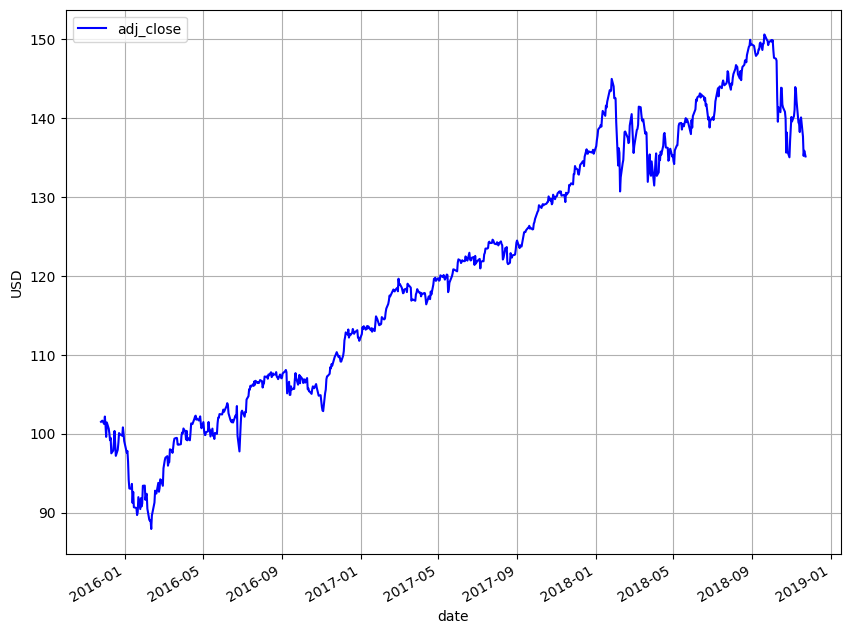

In [28]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Feature Engineering

We will generate the following features:
* Mean 'adj_close' of each month
* Difference between high and low of each day
* Difference between open and close of each day
* Mean volume of each month

In [29]:
# Get difference between high and low of each day
df['range_hl'] = df['high'] - df['low']
df.drop(['high', 'low'], axis=1, inplace=True)

# Get difference between open and close of each day
df['range_oc'] = df['open'] - df['close']
df.drop(['open', 'close'], axis=1, inplace=True)

df.head()

,date,adj_close,volume,month,range_hl,range_oc
0,2015-11-25,101.497200,1820300,11,0.410004,0.040001
1,2015-11-27,101.648300,552400,11,0.540001,-0.040001
2,2015-11-30,101.213867,3618100,11,0.739997,0.610001
3,2015-12-01,102.167740,2443600,12,0.839996,-0.590004
4,2015-12-02,101.100533,2937200,12,1.390000,1.049995


Now we use lags up to N number of days to use as features.

In [30]:
# Add a column 'order_day' to indicate the order of the rows by date
df['order_day'] = [x for x in list(range(len(df)))]

# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']
lag_cols

['adj_close', 'range_hl', 'range_oc', 'volume']

In [31]:
shift_range = [x+1 for x in range(N)]

for shift in tqdm_notebook(shift_range):
    train_shift = df[merging_keys + lag_cols].copy()
    
    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
del train_shift

# Remove the first N rows which contain NaNs
df = df[N:]
    
df.head()

C:\Users\SAKSHI\AppData\Local\Temp\ipykernel_20868\232627498.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for shift in tqdm_notebook(shift_range):


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 748 entries, 7 to 754
Data columns (total 35 columns):
date               748 non-null datetime64[ns]
adj_close          748 non-null float64
volume             748 non-null int64
month              748 non-null int64
range_hl           748 non-null float64
range_oc           748 non-null float64
order_day          748 non-null int64
adj_close_lag_1    748 non-null float64
range_hl_lag_1     748 non-null float64
range_oc_lag_1     748 non-null float64
volume_lag_1       748 non-null float64
adj_close_lag_2    748 non-null float64
range_hl_lag_2     748 non-null float64
range_oc_lag_2     748 non-null float64
volume_lag_2       748 non-null float64
adj_close_lag_3    748 non-null float64
range_hl_lag_3     748 non-null float64
range_oc_lag_3     748 non-null float64
volume_lag_3       748 non-null float64
adj_close_lag_4    748 non-null float64
range_hl_lag_4     748 non-null float64
range_oc_lag_4     748 non-null float64
volume_lag_4  

In [ ]:
# # Get mean of adj_close of each month
# df_gb = df.groupby(['month'], as_index=False).agg({'adj_close':'mean'})
# df_gb = df_gb.rename(columns={'adj_close':'adj_close_mean'})
# df_gb

# # Merge to main df
# df = df.merge(df_gb, 
#               left_on=['month'], 
#               right_on=['month'],
#               how='left').fillna(0)

# # Merge to main df
# shift_range = [x+1 for x in range(2)]

# for shift in tqdm_notebook(shift_range):
#     train_shift = df[merging_keys + lag_cols].copy()
    
#     # E.g. order_day of 0 becomes 1, for shift = 1.
#     # So when this is merged with order_day of 1 in df, this will represent lag of 1.
#     train_shift['order_day'] = train_shift['order_day'] + shift
    
#     foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
#     train_shift = train_shift.rename(columns=foo)

#     df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
# del train_shift
    
# df

In [ ]:
# # Get mean of volume of each month
# df_gb = df.groupby(['month'], as_index=False).agg({'volume':'mean'})
# df_gb = df_gb.rename(columns={'volume':'volume_mean'})
# df_gb

# # Merge to main df
# df = df.merge(df_gb, 
#               left_on=['month'], 
#               right_on=['month'],
#               how='left').fillna(0)

# df.head()

# Split into train, cv and test set

In [ ]:
features = [
"adj_close_lag_1",
"range_hl_lag_1",
"range_oc_lag_1",
"volume_lag_1",
"adj_close_lag_2",
"range_hl_lag_2",
"range_oc_lag_2",
"volume_lag_2",
"adj_close_lag_3",
"range_hl_lag_3",
"range_oc_lag_3",
"volume_lag_3",
"adj_close_lag_4",
"range_hl_lag_4",
"range_oc_lag_4",
"volume_lag_4",
"adj_close_lag_5",
"range_hl_lag_5",
"range_oc_lag_5",
"volume_lag_5",
"adj_close_lag_6",
"range_hl_lag_6",
"range_oc_lag_6",
"volume_lag_6",
"adj_close_lag_7",
"range_hl_lag_7",
"range_oc_lag_7",
"volume_lag_7"
]

target = "adj_close"

# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]

# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (450, 28)
y_train.shape = (450,)
X_cv.shape = (149, 28)
y_cv.shape = (149,)
X_train_cv.shape = (599, 28)
y_train_cv.shape = (599,)
X_sample.shape = (149, 28)
y_sample.shape = (149,)


# EDA

Text(0, 0.5, 'USD')

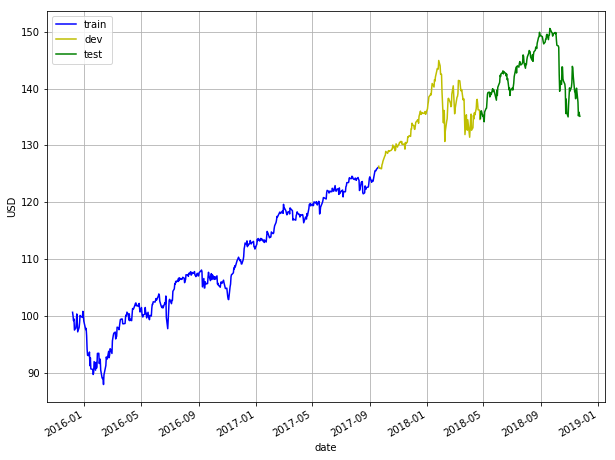

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Train the model using XGBoost

In [ ]:
# Create the model
model = XGBRegressor(seed=model_seed,
                      n_estimators=n_estimators,
                      max_depth=max_depth,
                      learning_rate=learning_rate,
                      min_child_weight=min_child_weight)

# Train the regressor
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
       silent=True, subsample=1)

# Predict on train set

In [ ]:
# Do prediction on train set
est = model.predict(X_train)

# Calculate RMSE
math.sqrt(mean_squared_error(y_train, est))

0.4218812527374346

Text(0, 0.5, 'USD')

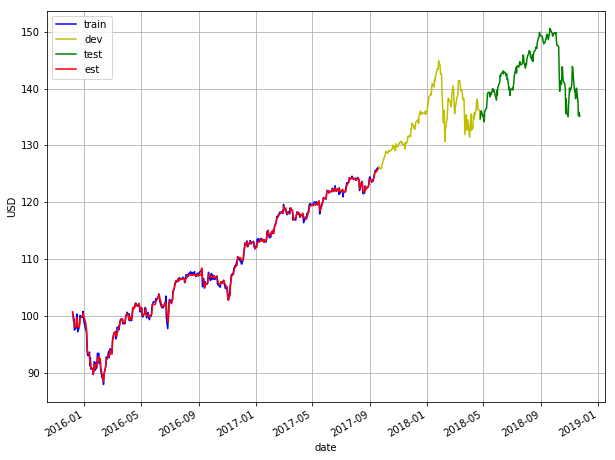

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'est'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Predict on dev set

In [ ]:
# Do prediction on test set
est = model.predict(X_cv)

# Calculate RMSE
print("RMSE = " + str(math.sqrt(mean_squared_error(y_cv, est))))

RMSE = 10.320713612000851


Text(0, 0.5, 'USD')

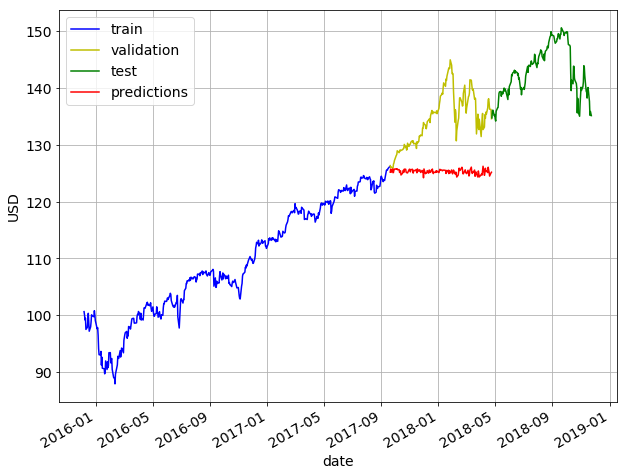

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

est_df = pd.DataFrame({'est': est, 
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Findings
* Doesn't work well
* Likely because the model was trained on prices below 125 and so when it saw prices above 125 for the dev set, it could not generalize well.
* Should try to normalize the data